In [97]:
import os
import pandas as pd
import supereeg as se
import numpy as np
import copy
import nibabel as nib
from nilearn import plotting as ni_plt
from nilearn.image import resample_img
from nilearn import datasets, image
from scipy.spatial.distance import pdist, cdist
import scipy 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, IncrementalPCA
import matplotlib.colors as mplcol
import matplotlib as mpl
import seaborn as sns
from scipy.io import loadmat

In [2]:
def rbf(centers, widths, locs):
    """
    Radial basis function
    Parameters
    ----------
    centers : ndarray
        rbf coordinates (one row per RBF)
    widths : ndarray
        RBF radii
    locs : ndarray
        locations to evaluate the RBFs (one row per location)
        
    Returns
    ----------
    results : ndarray
        Matrix of RBF weights for each RBF (row), at each location (column)
    """    
    weights = np.exp(np.divide(-cdist(locs, centers, metric='euclidean') ** 2, np.tile(np.array(widths, ndmin=2), [locs.shape[0], 1])))
    return weights.T

In [3]:

def _near_neighbor(bo, full_bo): #TODO: should this be part of bo.get_locs() or Brain.__init__, or possibly model.__init__?
    """
    Finds the nearest voxel for each subject's electrode location and uses
    that as revised electrodes location matrix in the prediction.

    Parameters
    ----------

    bo : Brain object
        Brain object to update

    full_bo : Brain object
        Brain object for the nearests locations used to predict


    Returns
    ----------
    bo : Brain object
        A new updated brain object

    """

    nbo = copy.deepcopy(bo) #FIXME: copying is expensive...
    nbo.orig_locs = nbo.locs
    d = cdist(nbo.locs, full_bo.locs, metric='Euclidean')
    for i in range(len(nbo.locs)):
        min_ind = list(zip(*np.where(d == d[i].min())))[0]
        nbo.data.iloc[:, min_ind[0]] = full_bo.data.iloc[:, min_ind[1]]
    return nbo


In [4]:
n_nets = 7

In [5]:
pwd

'/Users/lucyowen/repos/pca_paper/code/notebooks'

In [6]:
fig_dir = '../../paper/figs/source/networks'
network_dir = '../../data/yeo_networks'

In [7]:
nii_bo_dir = '../../data/niis'
pca_nii_bo_dir = os.path.join(nii_bo_dir, 'pcas')
if not os.path.exists(pca_nii_bo_dir):
    os.makedirs(pca_nii_bo_dir)
networks_nii_bo_dir = os.path.join(nii_bo_dir, 'networks')
if not os.path.exists(networks_nii_bo_dir):
    os.makedirs(networks_nii_bo_dir)
    

In [8]:
template = se.helpers._std(res=4)

/usr/local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [9]:
ddir = '../../data/'

In [10]:
posterior = loadmat(os.path.join(ddir, 'pieman_posterior_K700.mat'))
centers = posterior['posterior']['centers'][0][0][0][0][0]
widths = np.array(list(posterior['posterior']['widths'][0][0][0][0][0][:, 0].T))

In [11]:
yeo_colors = pd.read_fwf(os.path.join(network_dir, 'Yeo2011_' + str(n_nets) + 'Networks_ColorLUT.txt'))
yeo_colors.columns = ["inds", "networks", "x", "y", "z", "labels"]


In [12]:
if n_nets == 17:
    yeo_color_labels = ['visual peripheral', 'visual central', 'somatomotor A', 'somatomotor B', 'dorsal attention A', 
                        'dorsal attention B', 'ventral attention', 'salience', 'limbic A', 'limbic B', 'control C', 
                        'control A', 'control B', 'default D (auditory)', 'default C', 'default A', 'default B']
elif n_nets == 7:
    yeo_color_labels = ['Visual', 'Somatomotor', 'Dorsal Attention', 'Ventral Attention', 'Limbic ',
                        'Frontoparietal', 'Default']
    
yeo_colors['labels'] = yeo_color_labels

In [13]:
yeo_colors

inds     networks    x    y    z             labels
0     1  7Networks_1  120   18  134             Visual
1     2  7Networks_2   70  130  180        Somatomotor
2     3  7Networks_3    0  118   14   Dorsal Attention
3     4  7Networks_4  196   58  250  Ventral Attention
4     5  7Networks_5  220  248  164            Limbic 
5     6  7Networks_6  230  148   34     Frontoparietal
6     7  7Networks_7  205   62   78            Default

In [14]:
yeo_file = os.path.join(network_dir, 'Yeo2011_'+ str(n_nets) + 'Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz')
yeo = se.load(yeo_file)

In [15]:
yeo.plot_glass_brain()

In [16]:
downsampled = 4
downsampled_nii = se.Nifti(resample_img(yeo, target_affine=np.eye(3)*downsampled, interpolation='nearest'))

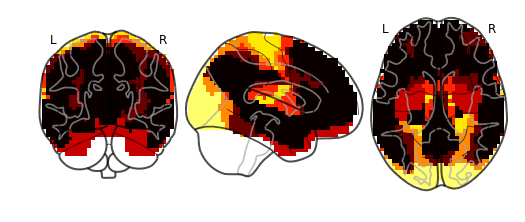

In [17]:
downsampled_nii.plot_glass_brain()

In [18]:
template = se.helpers._std(res=4)

/usr/local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [19]:
yeo_bo = se.Brain(downsampled_nii)

In [20]:
yeo_bo.save(os.path.join(networks_nii_bo_dir, 'yeo_bo.bo'))

In [21]:
# magma_colors = np.array([[0.368733  , 0.002724  , 0.650601  ],
#        [0.50022302, 0.01389304, 0.65714894],
#        [0.6201179 , 0.09824851, 0.61470924],
#        [0.86846771, 0.37314094, 0.39753518],
#        [0.93002341, 0.47633225, 0.32375425],
#        [0.97434661, 0.58904578, 0.24948002],
#        [0.99401233, 0.70882914, 0.18102124]])
# magma_colors.shape

In [22]:
### Just for 17! 
# magma_colors = color_stacked/255

In [23]:
# data_vals = yeo_bo.get_data().values.tolist()
# color_all = np.array([])
# for i, v in enumerate(data_vals[0]):
#     ind_color = int(v-1)
#     if color_all.shape[0]==0:
#         color_all = magma_colors[ind_color]
#     else:
#         color_all = np.vstack((color_all, magma_colors[ind_color]))


In [24]:

color_stacked = np.array([])
for i in np.arange(0,n_nets+1):
    if color_stacked.shape[0]==0:
        color_stacked = yeo_colors[yeo_colors.inds==i][['x', 'y', 'z']].values
    else:
        color_stacked = np.vstack((color_stacked, yeo_colors[yeo_colors.inds==i][['x', 'y', 'z']].values))
color_stacked = color_stacked/255

In [25]:
color_stacked

array([[0.47058824, 0.07058824, 0.5254902 ],
       [0.2745098 , 0.50980392, 0.70588235],
       [0.        , 0.4627451 , 0.05490196],
       [0.76862745, 0.22745098, 0.98039216],
       [0.8627451 , 0.97254902, 0.64313725],
       [0.90196078, 0.58039216, 0.13333333],
       [0.80392157, 0.24313725, 0.30588235]])

In [26]:

data_vals = yeo_bo.get_data().values.tolist()
color_all = np.array([])
for i, v in enumerate(data_vals[0]):
    ind_color = int(v-1)
    if color_all.shape[0]==0:
        color_all = color_stacked[ind_color]
    else:
        color_all = np.vstack((color_all, color_stacked[ind_color]))
        

In [27]:
yeo_bo.get_locs().as_matrix().shape

(16457, 3)

In [28]:
yeo_all_locs = yeo_bo.get_locs().as_matrix()
ni_plt.plot_connectome(np.eye(yeo_all_locs.shape[0]), yeo_all_locs, output_file=None,
                               node_kwargs={'alpha': 0.5, 'edgecolors': None},
                               node_size=10, node_color=color_all, display_mode='lyrz')



In [29]:
yeo_all_locs.shape

(16457, 3)

In [30]:
color_all.shape

(16457, 3)

In [31]:
# downsampled = 6
# downsampled_nii = se.Nifti(resample_img(yeo, target_affine=np.eye(3)*downsampled, interpolation='nearest'))

In [32]:
# yeo_bo = se.Brain(downsampled_nii)
# yeo_bo.save(os.path.join(networks_nii_bo_dir, 'yeo_bo_6mm.bo'))

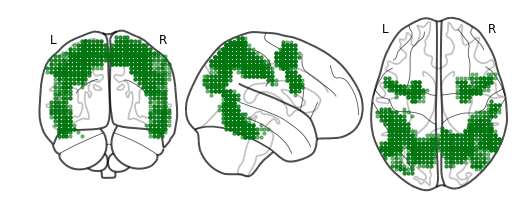

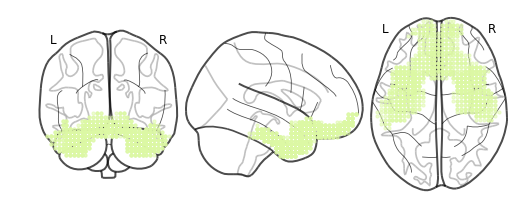

In [33]:
for n in np.arange(1, n_nets+1):
    mask_n = yeo_bo.get_data()==n
    masked_locs = yeo_bo.get_locs().as_matrix()[mask_n.as_matrix().ravel()]
    bo_n = se.Brain(data=np.atleast_2d(np.ones(masked_locs.shape[0])), locs=masked_locs)
    locs = bo_n.get_locs()
    #colors = magma_colors[n-1]
    colors = color_stacked[n-1]
    ni_plt.plot_connectome(np.eye(locs.shape[0]), locs, output_file=None,
                                   node_kwargs={'alpha': 0.5, 'edgecolors': None},
                                   node_size=10, node_color=colors)
    outfile = os.path.join(networks_nii_bo_dir, 'bo_network_' + str(n))
    bo_n.save(outfile)

In [34]:
yeo_nii = se.load(os.path.join(networks_nii_bo_dir, 'yeo_bo.bo'), return_type='nii', vox_size=4)




In [35]:
yeo_bo = se.load(os.path.join(networks_nii_bo_dir, 'yeo_bo.bo'))

In [36]:
yeo_bo.get_data()

0      1      2      3      4      5      6      7      8      9      \
0    7.0    7.0    7.0    7.0    7.0    7.0    7.0    2.0    4.0    7.0   

   ...    16447  16448  16449  16450  16451  16452  16453  16454  16455  16456  
0  ...      2.0    2.0    2.0    2.0    2.0    2.0    2.0    2.0    2.0    2.0  

[1 rows x 16457 columns]

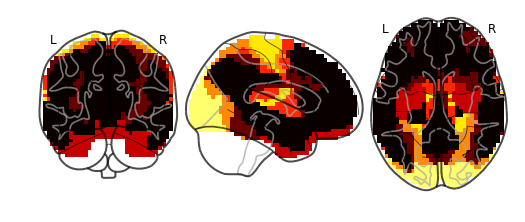

In [37]:
yeo_nii.plot_glass_brain()

In [69]:
sub_nii = se.load('std', vox_size=4)
sub_locs = sub_nii.get_locs().values
#sub_nii.save(os.path.join(fig_dir, '4mm_brain.nii'))

In [39]:
# conditions = ['intact']

# for e, c in enumerate(conditions):
    
#     for pc in np.arange(1) + 1:
        

#         b_file = os.path.join(pca_nii_bo_dir,f'{c}_{pc}_pca.bo')
#         pc_bo = se.load(b_file)
#         nii_bo_best = se.helpers._brain_to_nifti(pc_bo, sub_nii)
#         #pc_nii = se.load(b_file, return_type='nii', vox_size=4)
#         nii_bo_best.plot_glass_brain()
#         mask = nii_bo_best.get_data() > 0
#         rounded_vals = np.round_(yeo_nii.get_data()[mask])
#         counts = np.array(np.unique(rounded_vals[~np.isnan(rounded_vals)], return_counts=True))
#         #counts = np.array(np.unique(yeo_nii.get_data()[mask], return_counts=True))
        
#         copied = yeo_nii.get_data().copy()

In [40]:
# conditions = ['intact', 'paragraph', 'rest', 'word']
# #conditions = ['word']

# for e, c in enumerate(conditions):
    
#     for pc in np.arange(4) + 1:
        

#         b_file = os.path.join(pca_nii_bo_dir,f'{c}_{pc}_pca.bo')
#         pc_bo = se.load(b_file)
#         nii_bo_best = se.helpers._brain_to_nifti(pc_bo, sub_nii)
#         #pc_nii = se.load(b_file, return_type='nii', vox_size=4)
#         nii_bo_best.plot_glass_brain()
#         mask = nii_bo_best.get_data() > 0
#         rounded_vals = np.round_(yeo_nii.get_data()[mask])
#         counts = np.array(np.unique(rounded_vals[~np.isnan(rounded_vals)], return_counts=True))
#         #counts = np.array(np.unique(yeo_nii.get_data()[mask], return_counts=True))
        
#         copied = yeo_nii.get_data().copy()
#         copied[mask + 0 == 0] = 0.
#         #mask = mask *1
        
#         #copied[mask] = 0
#         temp_mask = se.Nifti(copied, nii_bo_best.get_affine())
#         temp_mask.plot_glass_brain()
#         temp_bo = se.Brain(temp_mask)
#         temp_bo.plot_locs()
#         outfile = os.path.join(networks_nii_bo_dir, f'{c}_{pc}_network.bo')
#         temp_bo.save(outfile)

#         data_vals = temp_bo.get_data().values.tolist()
#         color_all = np.array([])
#         for i, v in enumerate(data_vals[0]):
#             ind_color = int(v-1)
#             if color_all.shape[0]==0:
#                 color_all = color_stacked[ind_color]
#             else:
#                 color_all = np.vstack((color_all, color_stacked[ind_color]))


#         locs = temp_bo.get_locs().as_matrix()
#         ni_plt.plot_connectome(np.eye(locs.shape[0]), locs, output_file=None,
#                                        node_kwargs={'alpha': 0.5, 'edgecolors': None},
#                                        node_size=10, node_color=color_all)


#         ni_plt.show()

#         nets = counts[0][counts[0]>0]
#         counts = counts[1][counts[0]>0]

#         pie_colors = np.array([])
#         color_labels = []

#         for net in nets:
#             n = int(round(net))
#             if pie_colors.shape[0]==0:
#                 pie_colors = color_stacked[int(n-1)]
#                 color_labels.append(yeo_colors[yeo_colors.inds==n]['labels'].values[0])
#             else:
#                 pie_colors = np.vstack((pie_colors, color_stacked[int(n-1)]))
#                 color_labels.append(yeo_colors[yeo_colors.inds==n]['labels'].values[0])

#         print(color_labels)

#         #scale_pie = np.array(mean_best_loc[mean_best_loc['Freq']==f]['Normed_corr'])[0]
#         #scale_pie = np.array(mean_best_loc[mean_best_loc['Freq']==f]['new_normed_corr'])[0]
#         scale_pie = 1
#         print(scale_pie)
#         size = 1

#         fig = plt.figure(figsize=[10*scale_pie, 10*scale_pie])
#         patches, texts = plt.pie(counts/counts.sum(), colors=sns.color_palette(pie_colors), radius=scale_pie, shadow=False, startangle=90, wedgeprops=dict(width=scale_pie, edgecolor='w'))
#         #plt.legend(patches, color_labels, loc='upper left', bbox_to_anchor=(0.95, .45, 0.5, 0.5), fontsize = 'large')
#         #plt.axis('equal')
#         #plt.tight_layout()
#         pie_outfile = os.path.join(fig_dir, c + '_'+ str(pc) + '_network_pie.pdf')
#         #plt.savefig(pie_outfile)
#         plt.show()   

In [70]:
temp_locs = centers
temp_widths = widths
w = rbf(temp_locs, temp_widths, sub_nii.get_locs().values)
b_o = se.Brain(data=np.array(np.sum(w, axis=0), ndmin=2), locs=template.get_locs(), minimum_voxel_size=4)


In [71]:
b_o.locs

x     y     z
0      69.0 -57.0  -3.0
1      69.0 -57.0   1.0
2      69.0 -57.0   5.0
3      69.0 -53.0  -7.0
4      69.0 -53.0  -3.0
5      69.0 -53.0   1.0
6      69.0 -53.0   5.0
7      69.0 -53.0   9.0
8      69.0 -49.0 -11.0
9      69.0 -49.0  -7.0
10     69.0 -49.0  -3.0
11     69.0 -49.0   1.0
12     69.0 -49.0   5.0
13     69.0 -49.0   9.0
14     69.0 -49.0  13.0
15     69.0 -49.0  17.0
16     69.0 -45.0 -11.0
17     69.0 -45.0  -7.0
18     69.0 -45.0  -3.0
19     69.0 -45.0   1.0
20     69.0 -45.0   5.0
21     69.0 -45.0   9.0
22     69.0 -45.0  13.0
23     69.0 -45.0  17.0
24     69.0 -41.0 -15.0
25     69.0 -41.0 -11.0
26     69.0 -41.0  -7.0
27     69.0 -41.0  -3.0
28     69.0 -41.0   1.0
29     69.0 -41.0   5.0
...     ...   ...   ...
34656 -71.0 -37.0  -3.0
34657 -71.0 -37.0   1.0
34658 -71.0 -37.0   5.0
34659 -71.0 -37.0   9.0
34660 -71.0 -33.0 -11.0
34661 -71.0 -33.0  -7.0
34662 -71.0 -33.0  -3.0
34663 -71.0 -33.0   1.0
34664 -71.0 -33.0   5.0
34665 -71.0 -33.0   9.0
34666 -71.0 -29.0 -11.0
34667 -71.0 -29.0  -7.0
34668 -71.0 -29.0  -3.0
34669 -71.0 -29.0   1.0
34670 -71.0 -29.0   5.0
34671 -71.0 -29.0   9.0
34672 -71.0 -25.0 -11.0
34673 -71.0 -25.0  -7.0
34674 -71.0 -25.0  -3.0
34675 -71.0 -25.0   1.0
34676 -71.0 -25.0   5.0
34677 -71.0 -25.0   9.0
34678 -71.0 -21.0 -11.0
34679 -71.0 -21.0  -7.0
34680 -71.0 -21.0  -3.0
34681 -71.0 -21.0   5.0
34682 -71.0 -21.0   9.0
34683 -71.0 -17.0 -11.0
34684 -71.0 -17.0  -7.0
34685 -71.0 -13.0 -11.0

[34686 rows x 3 columns]

In [72]:
b_o.locs

x     y     z
0      69.0 -57.0  -3.0
1      69.0 -57.0   1.0
2      69.0 -57.0   5.0
3      69.0 -53.0  -7.0
4      69.0 -53.0  -3.0
5      69.0 -53.0   1.0
6      69.0 -53.0   5.0
7      69.0 -53.0   9.0
8      69.0 -49.0 -11.0
9      69.0 -49.0  -7.0
10     69.0 -49.0  -3.0
11     69.0 -49.0   1.0
12     69.0 -49.0   5.0
13     69.0 -49.0   9.0
14     69.0 -49.0  13.0
15     69.0 -49.0  17.0
16     69.0 -45.0 -11.0
17     69.0 -45.0  -7.0
18     69.0 -45.0  -3.0
19     69.0 -45.0   1.0
20     69.0 -45.0   5.0
21     69.0 -45.0   9.0
22     69.0 -45.0  13.0
23     69.0 -45.0  17.0
24     69.0 -41.0 -15.0
25     69.0 -41.0 -11.0
26     69.0 -41.0  -7.0
27     69.0 -41.0  -3.0
28     69.0 -41.0   1.0
29     69.0 -41.0   5.0
...     ...   ...   ...
34656 -71.0 -37.0  -3.0
34657 -71.0 -37.0   1.0
34658 -71.0 -37.0   5.0
34659 -71.0 -37.0   9.0
34660 -71.0 -33.0 -11.0
34661 -71.0 -33.0  -7.0
34662 -71.0 -33.0  -3.0
34663 -71.0 -33.0   1.0
34664 -71.0 -33.0   5.0
34665 -71.0 -33.0   9.0
34666 -71.0 -29.0 -11.0
34667 -71.0 -29.0  -7.0
34668 -71.0 -29.0  -3.0
34669 -71.0 -29.0   1.0
34670 -71.0 -29.0   5.0
34671 -71.0 -29.0   9.0
34672 -71.0 -25.0 -11.0
34673 -71.0 -25.0  -7.0
34674 -71.0 -25.0  -3.0
34675 -71.0 -25.0   1.0
34676 -71.0 -25.0   5.0
34677 -71.0 -25.0   9.0
34678 -71.0 -21.0 -11.0
34679 -71.0 -21.0  -7.0
34680 -71.0 -21.0  -3.0
34681 -71.0 -21.0   5.0
34682 -71.0 -21.0   9.0
34683 -71.0 -17.0 -11.0
34684 -71.0 -17.0  -7.0
34685 -71.0 -13.0 -11.0

[34686 rows x 3 columns]

In [73]:
nii_bo_best = se.helpers._brain_to_nifti(b_o, sub_nii)

In [74]:
nii_bo_best.plot_glass_brain()

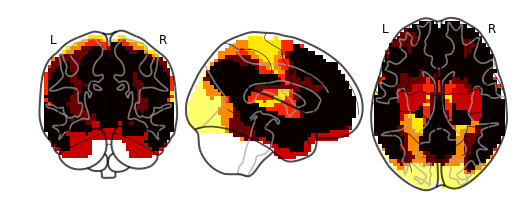

In [75]:
copied = yeo_nii.get_data().copy()
yeo_mask = se.Nifti(copied, nii_bo_best.get_affine())
yeo_mask.plot_glass_brain()
yeo_mask_bo = se.Brain(yeo_mask)
yeo_all_locs = yeo_mask_bo.get_locs().as_matrix()

In [77]:
centers_bo = se.Brain(data=np.ones((1, centers.shape[0])), locs=centers)
nii_bo_center = se.helpers._brain_to_nifti(centers_bo, sub_nii)
bo_niis =se.Brain(nii_bo_center)
bo_nii_locs = bo_niis.get_locs().as_matrix()

In [78]:
bo_niis.plot_locs()

In [79]:
bo_nii_locs.shape

(698, 3)

In [80]:
bo_niis.data

0    1    2    3    4    5    6    7    8    9   ...   688  689  690  691  \
0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0  1.0   

   692  693  694  695  696  697  
0  1.0  1.0  1.0  1.0  1.0  1.0  

[1 rows x 698 columns]

In [81]:
all_inds = se.helpers.get_rows(yeo_all_locs, bo_nii_locs)

In [83]:
color_all[all_inds].shape

(520, 3)

In [84]:
bo_nii_locs.shape

(698, 3)

In [85]:
yeo_all_locs.shape

(16457, 3)

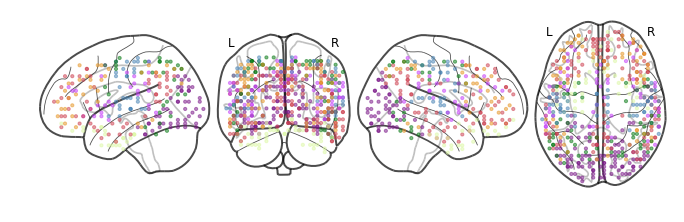

In [86]:
#yeo_all_locs = yeo_bo.get_locs().as_matrix()
ni_plt.plot_connectome(np.eye(yeo_all_locs[all_inds].shape[0]), yeo_all_locs[all_inds], output_file=None,
                               node_kwargs={'alpha': 0.5, 'edgecolors': None},
                               node_size=10, node_color=color_all[all_inds], display_mode='lyrz')



In [59]:
bo = se.Brain(data=np.array(widths, ndmin=2), locs=centers)

In [60]:
network_bo = _near_neighbor(bo,yeo_bo)

In [ ]:
network_bo

In [220]:
network_bo_outfile = os.path.join('/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/data', 'networks.bo')
network_bo.save(network_bo_outfile)

In [217]:
ddir

'../../data/'

(183, 3)
(58, 3)
(64, 3)
(82, 3)
(76, 3)
(94, 3)
(143, 3)


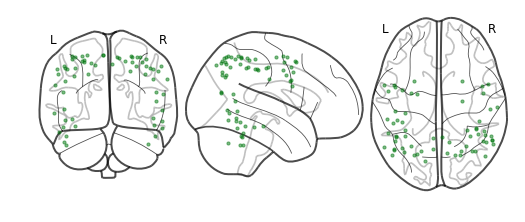

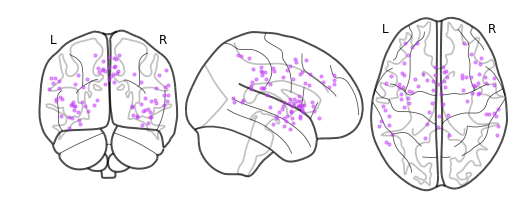

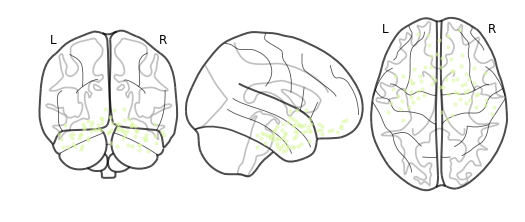

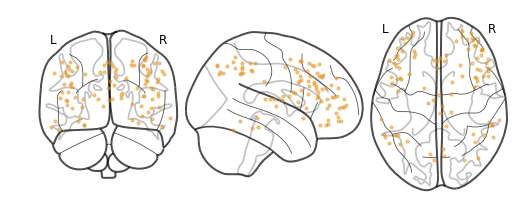

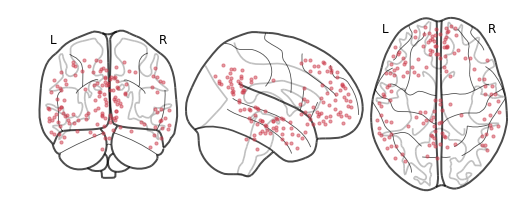

In [221]:
for n in np.arange(1, n_nets+1):
    mask_n = network_bo.get_data()==n
    masked_locs = network_bo.get_locs().as_matrix()[mask_n.as_matrix().ravel()]
    bo_n = se.Brain(data=np.atleast_2d(np.ones(masked_locs.shape[0])), locs=masked_locs)
    locs = bo_n.get_locs()
    print(locs.shape)
    colors = color_stacked[n-1]
    ni_plt.plot_connectome(np.eye(locs.shape[0]), locs, output_file=None,
                                   node_kwargs={'alpha': 0.5, 'edgecolors': None},
                                   node_size=10, node_color=colors)


In [98]:
factors=700
debug=False
if factors == 100:
    pieman_name = '../../data/pieman_ica100.mat'
else:
    pieman_name ='../../data/pieman_data.mat'

pieman_conds = ['intact', 'paragraph', 'word', 'rest']
pieman_data = loadmat(pieman_name)

In [99]:

if debug:
    data = []
    conds = []
    for c in pieman_conds:
        next_data = list(map(lambda i: pieman_data[c][:, i][0][:30, :10], np.where(np.arange(pieman_data[c].shape[1]) != 3)[0]))
        data.extend(next_data)
        conds.extend([c]*len(next_data))
    del pieman_data

else:

    data = []
    conds = []
    for c in pieman_conds:
        if c == 'paragraph':
            if factors == 700:
                next_data = list(map(lambda i: pieman_data[c][:, i][0], np.where(np.arange(pieman_data[c].shape[1]) != 3)[0]))
            else:
                next_data = list(map(lambda i: pieman_data[c][:, i][0], np.where(np.arange(pieman_data[c].shape[1]) != 0)[0]))
        else:
            next_data = list(map(lambda i: pieman_data[c][:, i][0], np.arange(pieman_data[c].shape[1])))
        data.extend(next_data)
        conds.extend([c]*len(next_data))
    del pieman_data

In [100]:
data = np.array(data)
conds = np.array(conds)

In [101]:
pwd

'/Users/lucyowen/repos/pca_paper/code/notebooks'

In [113]:
network_cmaps = ["Purples", "Greens", "Blues", "RdPu", "YlGnBu", "YlOrRd", "Reds"]

Visual


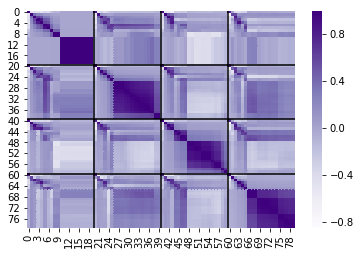

Somatomotor


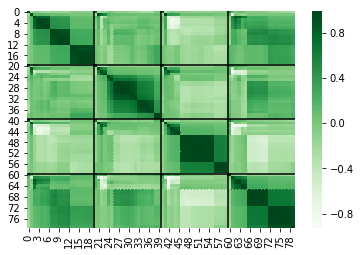

Dorsal Attention


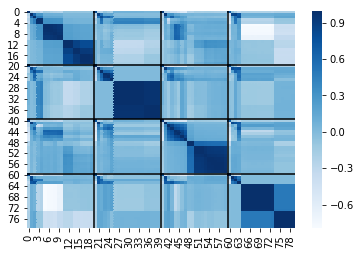

Ventral Attention


Limbic 


Frontoparietal


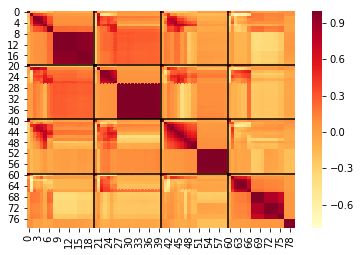

Default


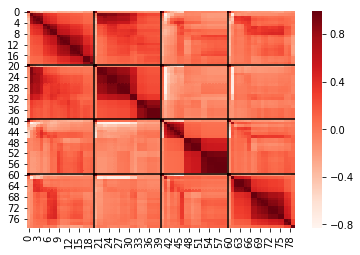

<Figure size 432x288 with 0 Axes>

In [114]:
conditions = ['intact', 'paragraph', 'word', 'rest']
#conditions = ['intact']

for n in np.arange(1, n_nets+1):
    mask_n = network_bo.get_data()==n
    print(yeo_colors[yeo_colors.inds==n]['labels'].values[0])
    n_comps = 20
    stacked_conditions = np.array([])
    for c in conditions:
        x = list(data[conds == c])
        split = np.cumsum([len(xi) for xi in x])[:-1]

        pca = IncrementalPCA(n_components=20)
        x_r = np.vsplit(pca.fit_transform(np.vstack(x)[:, mask_n.as_matrix().flatten()]), split)

        stacked_dims = np.array([])
        try_divide = np.divide(pca.components_.T, pca.components_.mean(axis=1)).T

        for i in np.arange(n_comps):

            try_divide[:i+1].sum(axis=0)

            if stacked_dims.shape[0]==0:
                stacked_dims = try_divide[:i+1].sum(axis=0)
            else:
                stacked_dims = np.vstack((stacked_dims, try_divide[:i+1].sum(axis=0)))  

        if stacked_conditions.shape[0]==0:
            stacked_conditions = stacked_dims
        else:
            stacked_conditions = np.vstack((stacked_conditions, stacked_dims))

    heated = 1 - scipy.spatial.distance.cdist(stacked_conditions, stacked_conditions, 'correlation')

    ax = sns.heatmap(heated, cmap=network_cmaps[n-1])
    ax.hlines([n_comps, n_comps*2, n_comps*3], *ax.get_xlim())
    ax.vlines([n_comps, n_comps*2, n_comps*3], *ax.get_xlim())
    plt.show()
    plt.clf()

In [225]:
for n in np.arange(1, n_nets+1):
    mask_n = yeo_mask_bo.get_data()==n
    masked_locs = yeo_all_locs[mask_n.as_matrix().ravel()]
    bo_n = se.Brain(data=np.atleast_2d(np.ones(masked_locs.shape[0])), locs=masked_locs)
    locs = bo_n.get_locs()
    #colors = magma_colors[n-1]
    colors = color_stacked[n-1]
    ni_plt.plot_connectome(np.eye(locs.shape[0]), locs, output_file=None,
                                   node_kwargs={'alpha': 0.5, 'edgecolors': None},
                                   node_size=10, node_color=colors)


NameError: name 'yeo_mask_bo' is not defined

In [ ]:

b_file = os.path.join(pca_nii_bo_dir,f'{c}_{pc}_pca.bo')
pc_bo = se.load(b_file)
nii_bo_best = se.helpers._brain_to_nifti(pc_bo, sub_nii)
#pc_nii = se.load(b_file, return_type='nii', vox_size=4)
nii_bo_best.plot_glass_brain()
mask = nii_bo_best.get_data() > 0
rounded_vals = np.round_(yeo_nii.get_data()[mask])
counts = np.array(np.unique(rounded_vals[~np.isnan(rounded_vals)], return_counts=True))
#counts = np.array(np.unique(yeo_nii.get_data()[mask], return_counts=True))

copied = yeo_nii.get_data().copy()
copied[mask + 0 == 0] = 0.
#mask = mask *1

#copied[mask] = 0
temp_mask = se.Nifti(copied, nii_bo_best.get_affine())
temp_mask.plot_glass_brain()
temp_bo = se.Brain(temp_mask)
temp_bo.plot_locs()
outfile = os.path.join(networks_nii_bo_dir, f'{c}_{pc}_network.bo')
temp_bo.save(outfile)

data_vals = temp_bo.get_data().values.tolist()
color_all = np.array([])
for i, v in enumerate(data_vals[0]):
    ind_color = int(v-1)
    if color_all.shape[0]==0:
        color_all = color_stacked[ind_color]
    else:
        color_all = np.vstack((color_all, color_stacked[ind_color]))


locs = temp_bo.get_locs().as_matrix()
ni_plt.plot_connectome(np.eye(locs.shape[0]), locs, output_file=None,
                               node_kwargs={'alpha': 0.5, 'edgecolors': None},
                               node_size=10, node_color=color_all)


ni_plt.show()

nets = counts[0][counts[0]>0]
counts = counts[1][counts[0]>0]

pie_colors = np.array([])
color_labels = []

for net in nets:
    n = int(round(net))
    if pie_colors.shape[0]==0:
        pie_colors = color_stacked[int(n-1)]
        color_labels.append(yeo_colors[yeo_colors.inds==n]['labels'].values[0])
    else:
        pie_colors = np.vstack((pie_colors, color_stacked[int(n-1)]))
        color_labels.append(yeo_colors[yeo_colors.inds==n]['labels'].values[0])

print(color_labels)

#scale_pie = np.array(mean_best_loc[mean_best_loc['Freq']==f]['Normed_corr'])[0]
#scale_pie = np.array(mean_best_loc[mean_best_loc['Freq']==f]['new_normed_corr'])[0]
scale_pie = 1
print(scale_pie)
size = 1

fig = plt.figure(figsize=[10*scale_pie, 10*scale_pie])
patches, texts = plt.pie(counts/counts.sum(), colors=sns.color_palette(pie_colors), radius=scale_pie, shadow=False, startangle=90, wedgeprops=dict(width=scale_pie, edgecolor='w'))
#plt.legend(patches, color_labels, loc='upper left', bbox_to_anchor=(0.95, .45, 0.5, 0.5), fontsize = 'large')
#plt.axis('equal')
#plt.tight_layout()
pie_outfile = os.path.join(fig_dir, c + '_'+ str(pc) + '_network_pie.pdf')
#plt.savefig(pie_outfile)
plt.show()   

In [223]:
nets = counts[0][counts[0]>0]
counts = counts[1][counts[0]>0]

NameError: name 'counts' is not defined

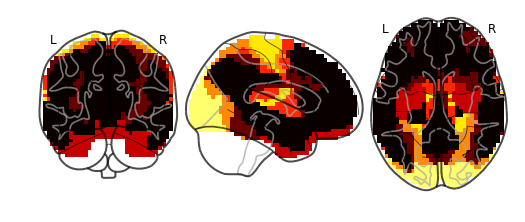

In [224]:
yeo_nii.plot_glass_brain()

In [31]:
mean_best_loc = pd.read_csv(os.path.join(freq_fig_dir, 'mean_best_loc.csv'))

In [32]:
raw_mean = mean_best_loc[mean_best_loc['Freq']=='raw']['Corr'][0]

In [33]:
mean_best_loc['Normed_corr'] = mean_best_loc['Corr']/raw_mean

In [34]:
mean_best_loc

Unnamed: 0      Corr       Freq  Normed_corr
0           0  0.522776        raw     1.000000
1           1  0.542936      delta     1.038563
2           2  0.576721      theta     1.103190
3           3  0.557029      alpha     1.065522
4           4  0.529582       beta     1.013019
5           5  0.459669     lgamma     0.879285
6           6  0.438820     hgamma     0.839404
7           7  0.641968  broadband     1.227999

In [35]:
mean_best_loc['Corr'].min()

0.4388200511486988

In [36]:
mean_best_loc['min_corr'] = mean_best_loc['Corr'] - mean_best_loc['Corr'].min()


In [37]:
mean_best_loc['new_normed_corr'] = mean_best_loc['min_corr']/mean_best_loc['min_corr'].max() + .5

raw


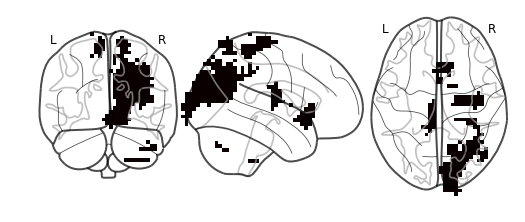

['Visual', 'Somatomotor', 'Dorsal Attention', 'Ventral Attention', 'Limbic ', 'Frontoparietal', 'Default']
0.913273887657788


delta


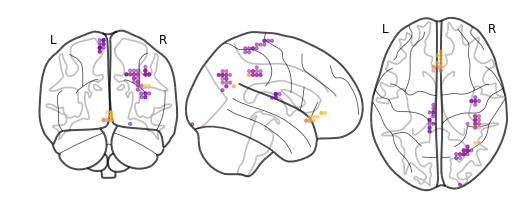

['Visual', 'Somatomotor', 'Dorsal Attention', 'Limbic ', 'Frontoparietal', 'Default']
1.0125113163288928


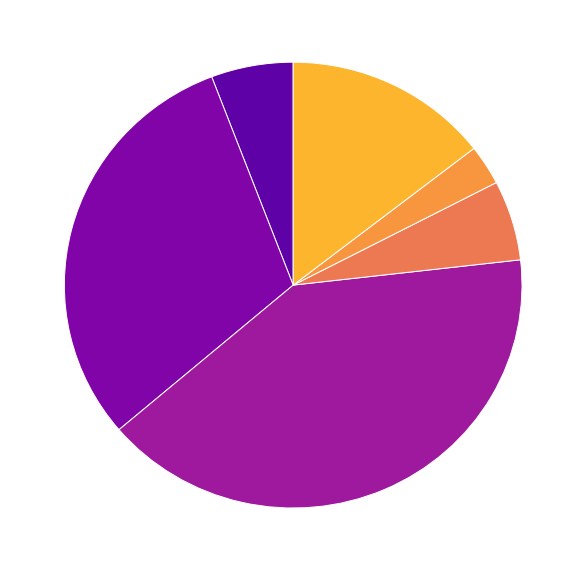

theta


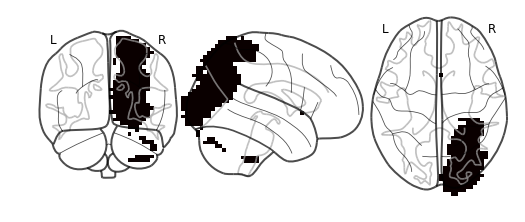

['Visual', 'Somatomotor', 'Dorsal Attention', 'Frontoparietal', 'Default']
1.1788213728711021


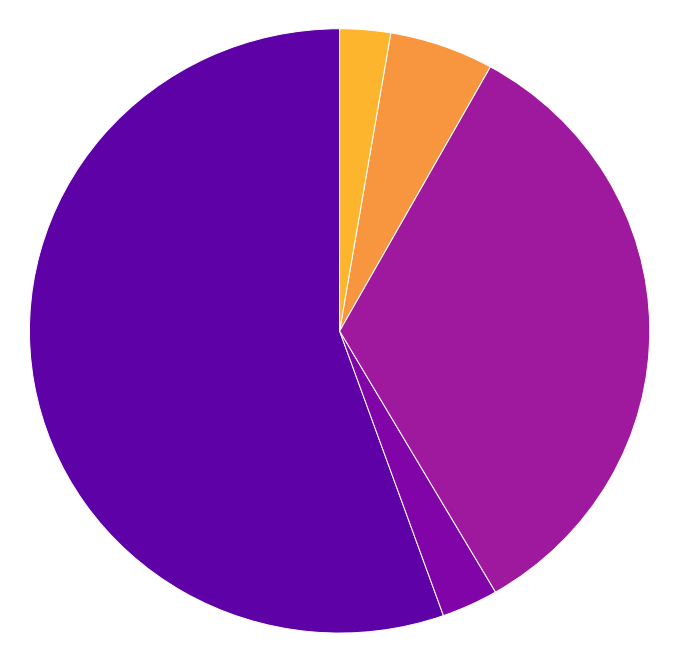

alpha


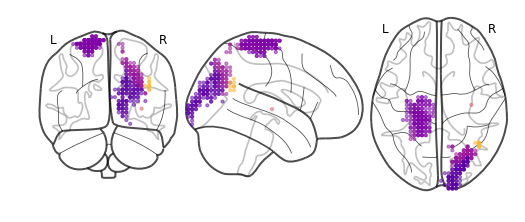

['Visual', 'Somatomotor', 'Dorsal Attention', 'Ventral Attention', 'Default']
1.0818858313834494


beta


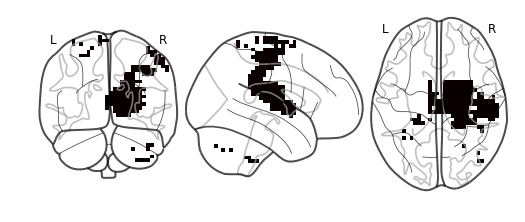

['Somatomotor', 'Dorsal Attention', 'Ventral Attention']
0.9467754184439305


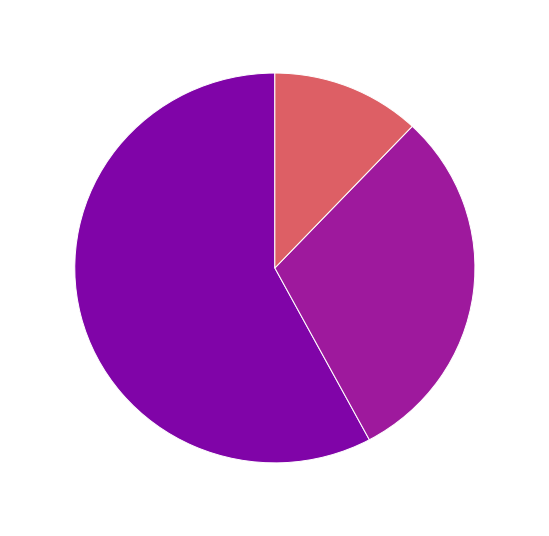

lgamma


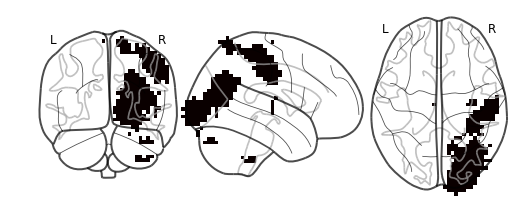

['Visual', 'Somatomotor', 'Dorsal Attention', 'Ventral Attention', 'Frontoparietal', 'Default']
0.6026297191757002


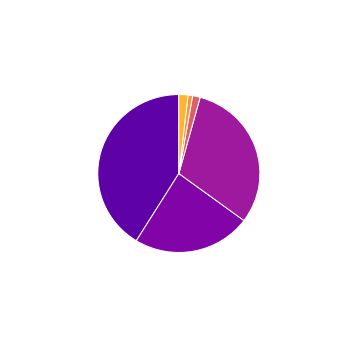

hgamma


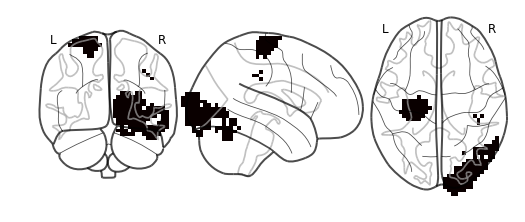

['Visual', 'Somatomotor', 'Dorsal Attention']
0.5


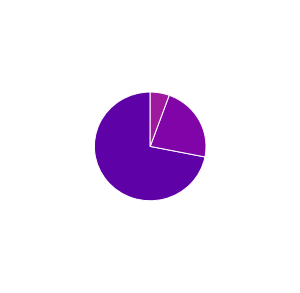

broadband


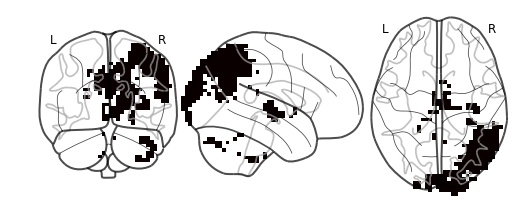

['Visual', 'Somatomotor', 'Dorsal Attention', 'Ventral Attention', 'Frontoparietal', 'Default']
1.5


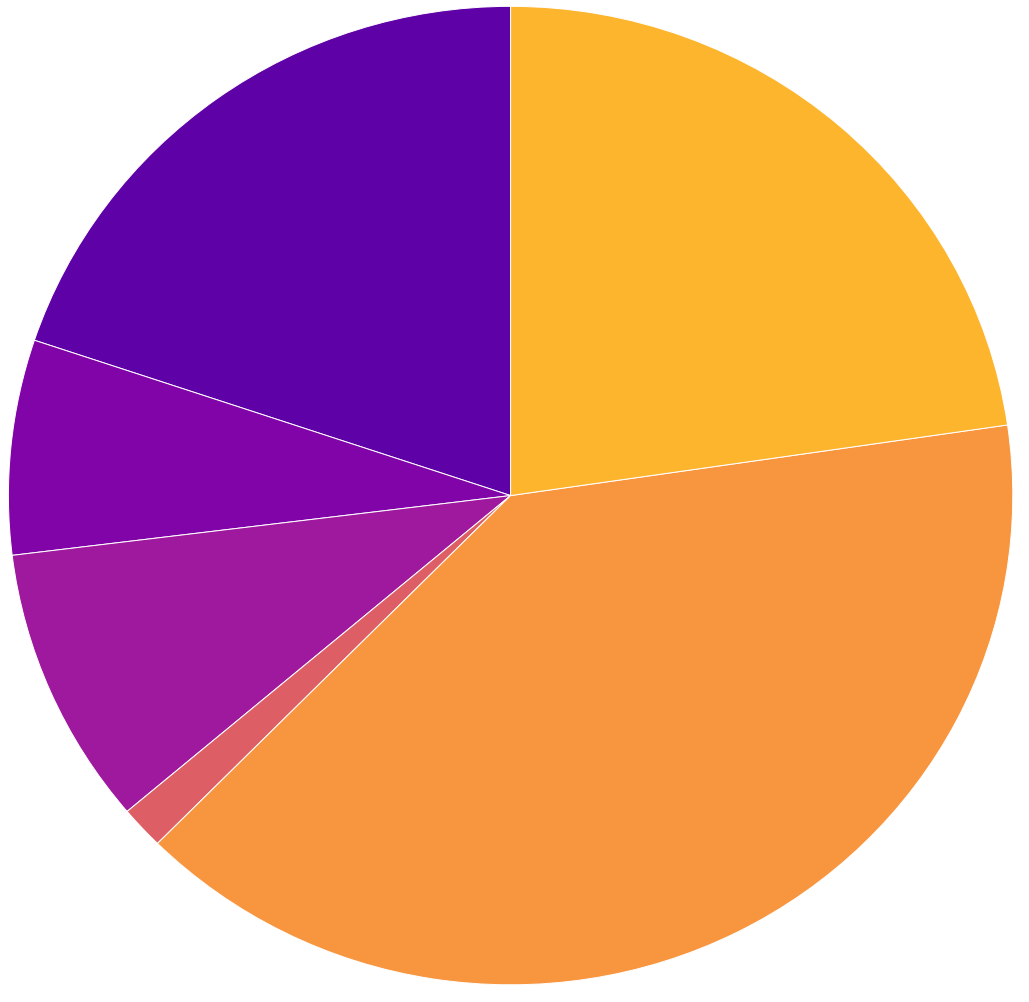

In [38]:
freqs = ['raw', 'delta', 'theta', 'alpha', 'beta', 'lgamma', 'hgamma', 'broadband']
for f in freqs:
    
    print(f)
    freq_file = os.path.join(freq_nii_bo_dir, f + '_best.bo')
    freq_nii = se.load(freq_file, return_type='nii')
    freq_nii.plot_glass_brain()
    mask = freq_nii.get_data() > 0
    counts = np.array(np.unique(yeo_nii.get_data()[mask], return_counts=True))
    
    copied = yeo_nii.get_data().copy()
    copied[mask + 0 == 0] = 0.
    temp_mask = se.Nifti(copied, yeo_nii.get_affine())
    temp_bo = se.Brain(temp_mask)
    
    outfile = os.path.join(networks_nii_bo_dir, f + '_network')
    temp_bo.save(outfile)
    
    data_vals = temp_bo.get_data().values.tolist()
    color_all = np.array([])
    for i, v in enumerate(data_vals[0]):
        ind_color = int(v-1)
        if color_all.shape[0]==0:
            color_all = magma_colors[ind_color]
        else:
            color_all = np.vstack((color_all, magma_colors[ind_color]))
        
            
    locs = temp_bo.get_locs().as_matrix()
    ni_plt.plot_connectome(np.eye(locs.shape[0]), locs, output_file=None,
                                   node_kwargs={'alpha': 0.5, 'edgecolors': None},
                                   node_size=10, node_color=color_all)


    ni_plt.show()
    
    nets = counts[0][counts[0]>0]
    counts = counts[1][counts[0]>0]
    
    pie_colors = np.array([])
    color_labels = []
            
    for c in nets:
    
        if pie_colors.shape[0]==0:
            pie_colors = magma_colors[int(c-1)]
            color_labels.append(yeo_colors[yeo_colors.inds==c]['labels'].values[0])
        else:
            pie_colors = np.vstack((pie_colors, magma_colors[int(c-1)]))
            color_labels.append(yeo_colors[yeo_colors.inds==c]['labels'].values[0])
    
    print(color_labels)
    
    #scale_pie = np.array(mean_best_loc[mean_best_loc['Freq']==f]['Normed_corr'])[0]
    scale_pie = np.array(mean_best_loc[mean_best_loc['Freq']==f]['new_normed_corr'])[0]
    
    print(scale_pie)
    size = 1
    
    fig = plt.figure(figsize=[10*scale_pie, 10*scale_pie])
    patches, texts = plt.pie(counts/counts.sum(), colors=sns.color_palette(pie_colors), radius=scale_pie, shadow=False, startangle=90, wedgeprops=dict(width=scale_pie, edgecolor='w'))
    #plt.legend(patches, color_labels, loc='upper left', bbox_to_anchor=(0.95, .45, 0.5, 0.5), fontsize = 'large')
    #plt.axis('equal')
    #plt.tight_layout()
    pie_outfile = os.path.join(fig_dir, f + '_network_pie.pdf')
    plt.savefig(pie_outfile)
    plt.show()   

In [39]:
yeo_colors['labels'].values.tolist()

['Visual',
 'Somatomotor',
 'Dorsal Attention',
 'Ventral Attention',
 'Limbic ',
 'Frontoparietal',
 'Default']

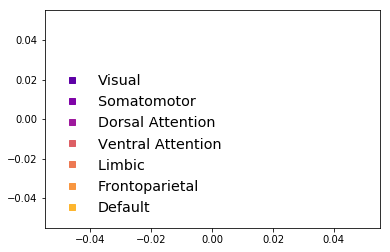

In [41]:
#colors = list(color_stacked/255)
colors = magma_colors
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colors[i]) for i in range(n_nets)]
labels = yeo_colors['labels'].values.tolist()
legend = plt.legend(handles, labels, loc=3, framealpha=1, frameon=False, fontsize = 'x-large')

def export_legend(legend, filename=os.path.join(fig_dir,'yeo_legend.pdf'), expand=[-1,-1,0,0]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

export_legend(legend)
plt.show()

In [51]:
try_nii = se.load('/Users/lucyowen/Downloads/reading_association-test_z_FDR_0.01.nii')

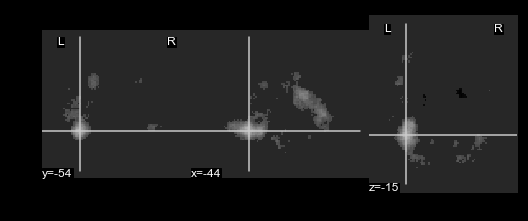

In [56]:
try_nii.plot_anat()

In [58]:
try_bo = se.Brain(try_nii)

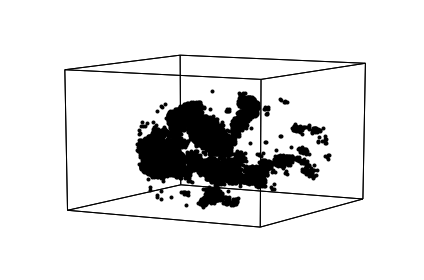

In [59]:
try_bo.plot_locs()

In [61]:
try_nii2 = se.Nifti(try_bo)

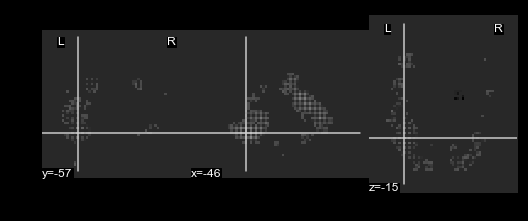

In [62]:
try_nii2.plot_anat()

In [63]:
try_nii2.save('/Users/lucyowen/Downloads/reading_supereeg_try')